In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
#import lightgbm as lgb

import random
import os
import re

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [2]:
path= '../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')


def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


# 데이터 전처리

## book 테이블

In [3]:
# books 테이블 전처리 부분 입니다.
# books의 이미지 변수를 지워줍니다.
# 제목과 요약 내용 변수를 지웁니다. 
# (이 변수들은 추후 사용 가능할수도 있으나 일단 지웁니다.)
# books의 publisher 변수 중 이름이 비슷한 변수들을 찾아 하나로 통일해줍니다.
books.drop(['book_title', 'summary', 'img_url', 'img_path'], axis = 1, inplace = True)

books_publishers = books.groupby('publisher')['isbn'].count().sort_values(ascending=False)
for i in books_publishers[books_publishers > 20].index: # 20 말고 10으로 하면 오류가 남..
    books['publisher'][books['publisher'].str.contains(i)] = i

In [4]:
# books의 카테고리 부분.

# 대괄호 써있는 카테고리 전치리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 모두 소문자로 통일
books['category'] = books['category'].str.lower()

# 수작업으로 higt 카테고리로 통합
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

books['category_high'] = books['category'].copy()
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [5]:
books['category_high'].value_counts()

fiction                                            39678
biography autobiography                             3326
history                                             1927
religion                                            1824
nonfiction                                          1427
                                                   ...  
buddhismus                                             1
heller jettero fictitious character                    1
persian gulf                                           1
procedure law                                          1
authors canadian english 20th century biography        1
Name: category_high, Length: 3270, dtype: int64

In [6]:
# language와 category_high NULL 값을 최빈값으로 채웁니다.
# 근거 : language == en일 때, category_high == fiction 일 때와
# 근거 : 값이 NULL 일 때 rating 평균이 7.0x로 유사한 형태.
books['language'].fillna('en', inplace = True)
books['category_high'].fillna('fiction', inplace = True)

In [7]:
# 출판연도 1970, 1980, 1990, 2000, 2020 으로 범주화 시킵니다.
# 딥러닝 과정에서 범주화 시키는 것이 유리합니다.
# 근거 : develop 파일에서 여러번 실험 결과 본 기준이 가장 rating을 잘 구분함.

books['years'] = books['year_of_publication'].copy()
books['years'][books['year_of_publication'] < 1970] = 1970
books['years'][(books['year_of_publication'] < 1980) * (books['year_of_publication'] >= 1970)] = 1980
books['years'][(books['year_of_publication'] < 1990) * (books['year_of_publication'] >= 1980)] = 1990
books['years'][(books['year_of_publication'] < 2000) * (books['year_of_publication'] >= 1990)] = 2000
books['years'][(books['year_of_publication'] >= 2000)] = 2020
books['years'] = books['years'].astype('str')
#books['years'] = books['years'].astype('int')
books.drop(['year_of_publication', 'category'], axis = 1, inplace = True)

## user 테이블

In [8]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

users['location_city'] = users['location_city'].map(loc_city2idx)
users['location_state'] = users['location_state'].map(loc_state2idx)
users['location_country'] = users['location_country'].map(loc_country2idx)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               40259 non-null  float64
 3   location_city     67970 non-null  object 
 4   location_state    66960 non-null  object 
 5   location_country  67821 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 3.1+ MB


In [117]:
# users['location_city'] = users['location'].apply(lambda x: x.split(',')[0])
# users['location_state'] = users['location'].apply(lambda x: x.split(',')[1])
# users['location_country'] = users['location'].apply(lambda x: x.split(',')[2])
# users = users.drop(['location'], axis=1)

# loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
# loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
# loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

# users['location_city'] = users['location_city'].map(loc_city2idx)
# users['location_state'] = users['location_state'].map(loc_state2idx)
# users['location_country'] = users['location_country'].map(loc_country2idx)

In [118]:
# # users 테이블 전처리 입니다.
# # location이 지역, 주, 국가로 되어있어 이 부분 기초 전처리 진행 과정입니다.

# users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

# # 지역, 주, 국가
# users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
# users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
# users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

# users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
# users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

# # 도시는 존재하는데 나라 정보가 없는 경우 채워주는 코드
# modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
# location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

# location_list = []
# for location in modify_location:
#     try:
#         right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
#         location_list.append(right_location)
#     except:
#         pass

# for location in location_list:
#     users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
#     users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

In [119]:
# # 저는 도시, 주, 국가 중 주를 선택했습니다.
# # 우선 모든 변수를 다 쓰는 건 아니라고 생각했어요. 도시 < 주 < 국가로 포함관계가 있기 때문이죠.
# # 데이터 분석 결과 주와 국가 단위가 비슷한 경우가 많은 것을 확인했습니다.
# # 조그만 섬 국가 < 미국 켈리포니아 주 < 미국 같은 경우죠.
# # 미국 같은 경우 미국으로 뭉뚱그리기 보다 주 단위로 나누는 것이 맞다고 판단했습니다.
# # 실제 미국 주 별로 rating 차이가 꽤 존재합니다.
# # 다만 도시 기준으로 나누면 너무 세분화 될 것 같다는 생각이 들었습니다.
# # 결론적으로 주를 지역을 나타내는 변수로 사용하기로 하고 결측값을 도시, 나라에서 채우기로 했습니다.

# def _fillna(x):
#     if pd.isna(x['location_country']):
#         # 만약 나라가 기록 안되있는 경우        
#         if pd.isna(x['location_city']):
#             # 도시까지 없다면 모든 정보가 없음. 최빈값 california 사용.
#             return 'california'
#         else:
#             tem = users['location_state'][users['location_city'] == x['location_city']].value_counts()
#             if len(tem) == 0: 
#                 # 만약 주 이름이 없는 도시이면 도시 이름을 주 이름으로 사용.
#                 return x['location_city'] 
#             else:
#                 # 그 도시에서 가장 자주 쓰이는 주 이름 사용.
#                 return tem.index[0]

#     else:
#         tem = users['location_state'][users['location_country'] == x['location_country']].value_counts()
#         if len(tem) == 0: 
#             # 만약 주 이름이 없는 나라이면 나라이름을 주 이름으로 사용.
#             return x['location_country'] 
#         else:
#             # 그 나라에서 가장 자주 쓰이는 주 이름 사용.
#             return tem.index[0]

# users['fix_location_state'] = users.apply(lambda x : _fillna(x) if pd.isna(x['location_state']) else x['location_state'], axis = 1)

In [10]:
users['fix_age'] = users['age'].copy()
users['fix_age'][users['age'] < 10] = 10
users['fix_age'][(users['age'] < 20) & (users['age'] >= 10)] = 20
users['fix_age'][(users['age'] < 30) & (users['age'] >= 20)] = 30
users['fix_age'][(users['age'] < 35) & (users['age'] >= 30)] = 35
users['fix_age'][(users['age'] < 40) & (users['age'] >= 35)] = 40
users['fix_age'][(users['age'] < 50) & (users['age'] >= 40)] = 50
users['fix_age'][users['age'] >= 50] = 100
users['fix_age'].fillna(10, inplace = True)
users['fix_age'] = users['fix_age'].astype('str') # users['fix_age'] = users['fix_age'].astype('int')

In [121]:
# users2 = pd.read_csv(path+'users.csv')
# users['age'] = users2['age']

In [122]:
# def age_map(x: int) -> int:
#     x = int(x)
#     if x < 20:
#         return 1
#     elif x >= 20 and x < 30:
#         return 2
#     elif x >= 30 and x < 40:
#         return 3
#     elif x >= 40 and x < 50:
#         return 4
#     elif x >= 50 and x < 60:
#         return 5
#     else:
#         return 6

# users['age'] = users['age'].fillna(users['age'].mean())
# users['age'] = users['age'].apply(age_map)

# users['age'].value_counts()

In [11]:
users = users[['user_id', 'location_city', 'location_state', 'location_country','fix_age']]
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           68092 non-null  int64 
 1   location_city     68092 non-null  int64 
 2   location_state    68092 non-null  int64 
 3   location_country  68092 non-null  int64 
 4   fix_age           68092 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.6+ MB


In [124]:
# n = 1

# def make_others(_column):
#     tem = pd.DataFrame(users[_column].value_counts()).reset_index()
#     tem.columns = ['names','count']
#     others_list = tem[tem['count'] <= n]['names'].values  # n은 초기에 설정함. 바꿀 수 있음.
#     users.loc[users[users[_column].isin(others_list)].index, _column]= 'others'

# def make_others2(_column):
#     tem = pd.DataFrame(books[_column].value_counts()).reset_index()
#     tem.columns = ['names','count']
#     others_list = tem[tem['count'] <= n]['names'].values  # n은 초기에 설정함. 바꿀 수 있음.
#     books.loc[books[books[_column].isin(others_list)].index, _column]= 'others'

# make_others('location_city')
# make_others('location_state')
# make_others('location_country')

# make_others2('book_author')
# make_others2('publisher')
# make_others2('category_high')

## rating 테이블과 merge

In [12]:
# 전처리 완료한 books와 users 테이블을 이용해 rating 테이블과 merge 하기.
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

train_ratings = pd.merge(train_ratings,books, how='right',on='isbn')
train_ratings.dropna(subset=['rating'], inplace = True)
train_ratings = pd.merge(train_ratings, users, how='right',on='user_id')
train_ratings.dropna(subset=['rating'], inplace = True)

test_ratings['index'] = test_ratings.index
test_ratings = pd.merge(test_ratings,books, how='right',on='isbn')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = pd.merge(test_ratings, users, how='right',on='user_id')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = test_ratings.sort_values('index')
test_ratings.drop(['index'], axis=1, inplace=True)

train_ratings['user_id'] = train_ratings['user_id'].astype('str')
test_ratings['user_id'] = test_ratings['user_id'].astype('str')

train_ratings['location_city'] = train_ratings['location_city'].astype('str')
test_ratings['location_city'] = test_ratings['location_city'].astype('str')

train_ratings['location_state'] = train_ratings['location_state'].astype('str')
test_ratings['location_state'] = test_ratings['location_state'].astype('str')

train_ratings['location_country'] = train_ratings['location_country'].astype('str')
test_ratings['location_country'] = test_ratings['location_country'].astype('str')


In [13]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 315083
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           306795 non-null  object 
 1   isbn              306795 non-null  object 
 2   rating            306795 non-null  float64
 3   book_author       306795 non-null  object 
 4   publisher         306795 non-null  object 
 5   language          306795 non-null  object 
 6   category_high     306795 non-null  object 
 7   years             306795 non-null  object 
 8   location_city     306795 non-null  object 
 9   location_state    306795 non-null  object 
 10  location_country  306795 non-null  object 
 11  fix_age           306795 non-null  object 
dtypes: float64(1), object(11)
memory usage: 30.4+ MB


# 모델링

In [16]:
# params_cat = {
#             "task_type" : "GPU",
#             "devices" : '0',
#             "random_state": SEED,
#             "learning_rate": 0.05,
#             "n_estimators": 2000,
#             "verbose" : 1,
#             "objective" : "RMSE",
#             "max_depth": 10,#trial.suggest_int("max_depth", 1, 16),
#             "colsample_bylevel": 1,#trial.suggest_float("colsample_bylevel", 0.8, 1.0),
#             #"subsample": 0.8, #trial.suggest_float("subsample", 0.3, 1.0), GPU 사용시 안될수도.
#             "min_child_samples": 50, #trial.suggest_int("min_child_samples", 5, 100),
#             "max_bin": 300, #trial.suggest_int("max_bin", 200, 500),
#             "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns)
#     }

params_cat = {
    "task_type" : "GPU",
    "devices" : '0',
    "random_state": SEED,
    'learning_rate': 0.04574578205475402, 
    'bagging_temperature': 0.12172958098369972, 
    'n_estimators': 8459, 
    'max_depth': 8, 
    'random_strength': 28, 
    'l2_leaf_reg': 1.6285455533915874e-05, 
    'min_child_samples': 18, 
    'max_bin': 441, 
    'od_type': 'Iter',
    "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
}

X_tr, X_val, y_tr, y_val = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2)

model = CatBoostRegressor(**params_cat)
model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    #early_stopping_rounds=10,
    verbose=False,
)

cat_pred = model.predict(X_val)
log_score = rmse(y_val, cat_pred)

print(log_score)

In [131]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(train_ratings, train_ratings['rating']):
  folds.append((train_idx,valid_idx))

In [156]:
random.seed(SEED)
cat_models={}

cat_features = list(range(1, 10))

def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    model = CatBoostRegressor(**param, task_type = 'GPU', devices = '0')

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    cat_pred = model.predict(X_valid)
    log_score = rmse(y_valid, cat_pred)

    return log_score

for fold in range(1,5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = train_ratings.drop(['rating'],axis = 1).iloc[train_idx]
    X_valid = train_ratings.drop(['rating'],axis = 1).iloc[valid_idx]
    y_train = train_ratings['rating'].iloc[train_idx]
    y_valid = train_ratings['rating'].iloc[valid_idx]

    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(
        study_name = 'cat_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=10)


    model = CatBoostRegressor(**study.best_params, task_type = 'GPU', devices = '0', random_state = SEED, objective = 'RMSE', cat_features = list(train_ratings.drop(['rating'],axis = 1).columns))
    model.fit(X_train, y_train)
                
    pred = model.predict(test_ratings.drop(['rating'],axis = 1))
    test_ratings[f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

====================================2============================================


[I 2022-11-01 06:10:29,585] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327672	test: 2.4325286	best: 2.4325286 (0)	total: 15.6ms	remaining: 1m 58s
100:	learn: 2.4275791	test: 2.4260900	best: 2.4260900 (100)	total: 2.12s	remaining: 2m 37s
200:	learn: 2.4275778	test: 2.4260772	best: 2.4260771 (191)	total: 4.36s	remaining: 2m 40s
bestTest = 2.426076782
bestIteration = 223
Shrink model to first 224 iterations.


[I 2022-11-01 06:10:39,011] Trial 0 finished with value: 2.4260770198204833 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4260770198204833.


0:	learn: 2.4331245	test: 2.4329368	best: 2.4329368 (0)	total: 13.2ms	remaining: 1m 52s
100:	learn: 2.4282068	test: 2.4270919	best: 2.4270919 (100)	total: 1.34s	remaining: 1m 51s
200:	learn: 2.4276497	test: 2.4262720	best: 2.4262720 (200)	total: 2.81s	remaining: 1m 55s
300:	learn: 2.4275868	test: 2.4261259	best: 2.4261259 (300)	total: 4.01s	remaining: 1m 49s
400:	learn: 2.4275794	test: 2.4260918	best: 2.4260916 (399)	total: 5.28s	remaining: 1m 46s
500:	learn: 2.4275784	test: 2.4260815	best: 2.4260815 (500)	total: 7.44s	remaining: 1m 58s
600:	learn: 2.4275783	test: 2.4260785	best: 2.4260785 (589)	total: 8.8s	remaining: 1m 55s
700:	learn: 2.4275778	test: 2.4260775	best: 2.4260775 (700)	total: 10.3s	remaining: 1m 54s
800:	learn: 2.4275778	test: 2.4260770	best: 2.4260770 (794)	total: 11.8s	remaining: 1m 53s
900:	learn: 2.4275778	test: 2.4260772	best: 2.4260770 (794)	total: 13.4s	remaining: 1m 52s
1000:	learn: 2.4275778	test: 2.4260772	best: 2.4260770 (794)	total: 14.8s	remaining: 1m 51s
11

[I 2022-11-01 06:13:04,709] Trial 1 finished with value: 2.426077106051661 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4260770198204833.


0:	learn: 2.4031356	test: 2.3980055	best: 2.3980055 (0)	total: 71.9ms	remaining: 4m 20s
100:	learn: 2.1880956	test: 2.1542823	best: 2.1542823 (100)	total: 4.21s	remaining: 2m 27s
200:	learn: 2.1634724	test: 2.1457746	best: 2.1457746 (200)	total: 7.78s	remaining: 2m 12s
300:	learn: 2.1456611	test: 2.1431973	best: 2.1431681 (297)	total: 11s	remaining: 2m 1s
400:	learn: 2.1303021	test: 2.1420613	best: 2.1420459 (399)	total: 14s	remaining: 1m 52s
500:	learn: 2.1162007	test: 2.1418984	best: 2.1418301 (489)	total: 18.2s	remaining: 1m 53s
600:	learn: 2.1034207	test: 2.1415107	best: 2.1414622 (599)	total: 22.5s	remaining: 1m 53s
700:	learn: 2.0911660	test: 2.1414849	best: 2.1413953 (621)	total: 25.1s	remaining: 1m 44s
800:	learn: 2.0800184	test: 2.1416799	best: 2.1413767 (714)	total: 27.7s	remaining: 1m 37s
900:	learn: 2.0679175	test: 2.1416882	best: 2.1413767 (714)	total: 30.2s	remaining: 1m 31s
1000:	learn: 2.0566727	test: 2.1418174	best: 2.1413767 (714)	total: 32.7s	remaining: 1m 25s
1100:	

[I 2022-11-01 06:14:46,649] Trial 2 finished with value: 2.1413766235445784 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1413766235445784.


0:	learn: 2.4019249	test: 2.4021611	best: 2.4021611 (0)	total: 509ms	remaining: 13m 26s
100:	learn: 1.9826294	test: 2.1554295	best: 2.1550053 (95)	total: 53s	remaining: 12m 58s
200:	learn: 1.4987196	test: 2.1699633	best: 2.1540821 (137)	total: 1m 43s	remaining: 11m 55s
300:	learn: 1.0842101	test: 2.1974225	best: 2.1540821 (137)	total: 2m 36s	remaining: 11m 7s
400:	learn: 0.8375269	test: 2.2122575	best: 2.1540821 (137)	total: 3m 26s	remaining: 10m 9s
500:	learn: 0.6746971	test: 2.2230375	best: 2.1540821 (137)	total: 4m 12s	remaining: 9m 5s
600:	learn: 0.5501225	test: 2.2308507	best: 2.1540821 (137)	total: 4m 57s	remaining: 8m 7s
700:	learn: 0.4664278	test: 2.2357944	best: 2.1540821 (137)	total: 5m 43s	remaining: 7m 12s
800:	learn: 0.3990605	test: 2.2396181	best: 2.1540821 (137)	total: 6m 28s	remaining: 6m 20s
900:	learn: 0.3490853	test: 2.2421549	best: 2.1540821 (137)	total: 7m 19s	remaining: 5m 33s
1000:	learn: 0.3077153	test: 2.2443702	best: 2.1540821 (137)	total: 8m 11s	remaining: 4m

[I 2022-11-01 06:27:55,039] Trial 3 finished with value: 2.154081863257307 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1413766235445784.


0:	learn: 2.4273600	test: 2.4269961	best: 2.4269961 (0)	total: 274ms	remaining: 5m 58s
100:	learn: 2.1951966	test: 2.2015410	best: 2.2015410 (100)	total: 24.9s	remaining: 4m 57s
200:	learn: 2.1243706	test: 2.1628217	best: 2.1628217 (200)	total: 49.6s	remaining: 4m 33s
300:	learn: 2.0858051	test: 2.1524162	best: 2.1524162 (300)	total: 1m 14s	remaining: 4m 8s
400:	learn: 2.0538323	test: 2.1473609	best: 2.1473609 (400)	total: 1m 39s	remaining: 3m 44s
500:	learn: 2.0258113	test: 2.1447376	best: 2.1447376 (500)	total: 2m 3s	remaining: 3m 19s
600:	learn: 1.9930204	test: 2.1429368	best: 2.1429368 (600)	total: 2m 28s	remaining: 2m 55s
700:	learn: 1.9626711	test: 2.1413158	best: 2.1413158 (700)	total: 2m 53s	remaining: 2m 30s
800:	learn: 1.9232338	test: 2.1403914	best: 2.1403826 (799)	total: 3m 18s	remaining: 2m 5s
900:	learn: 1.8676985	test: 2.1394278	best: 2.1394278 (900)	total: 3m 42s	remaining: 1m 40s
1000:	learn: 1.7894283	test: 2.1394978	best: 2.1392556 (973)	total: 4m 7s	remaining: 1m 16

[I 2022-11-01 06:33:27,541] Trial 4 finished with value: 2.139255470290954 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.139255470290954.


0:	learn: 2.3771073	test: 2.3855438	best: 2.3855438 (0)	total: 240ms	remaining: 37m 50s
bestTest = 2.269983025
bestIteration = 31
Shrink model to first 32 iterations.


[I 2022-11-01 06:33:43,163] Trial 5 finished with value: 2.2699831935917336 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.139255470290954.


0:	learn: 2.4202907	test: 2.4180008	best: 2.4180008 (0)	total: 28.7ms	remaining: 4m 2s
100:	learn: 2.2031333	test: 2.1654470	best: 2.1654470 (100)	total: 2.59s	remaining: 3m 34s
200:	learn: 2.1893425	test: 2.1545311	best: 2.1545311 (200)	total: 5.28s	remaining: 3m 36s
300:	learn: 2.1807290	test: 2.1500796	best: 2.1500796 (300)	total: 7.88s	remaining: 3m 33s
400:	learn: 2.1697717	test: 2.1462770	best: 2.1462770 (400)	total: 10.2s	remaining: 3m 25s
500:	learn: 2.1600721	test: 2.1439133	best: 2.1439120 (499)	total: 12.6s	remaining: 3m 19s
600:	learn: 2.1522218	test: 2.1423783	best: 2.1423783 (600)	total: 14.9s	remaining: 3m 15s
700:	learn: 2.1456159	test: 2.1417109	best: 2.1417109 (700)	total: 17.3s	remaining: 3m 11s
800:	learn: 2.1390583	test: 2.1409929	best: 2.1409929 (800)	total: 19.7s	remaining: 3m 8s
900:	learn: 2.1325081	test: 2.1402926	best: 2.1402926 (900)	total: 22.2s	remaining: 3m 6s
bestTest = 2.139823447
bestIteration = 969
Shrink model to first 970 iterations.


[I 2022-11-01 06:34:12,072] Trial 6 finished with value: 2.13982331512262 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 4 with value: 2.139255470290954.


0:	learn: 2.3702231	test: 2.3614322	best: 2.3614322 (0)	total: 143ms	remaining: 2m 29s
100:	learn: 1.8639551	test: 2.1691546	best: 2.1555588 (60)	total: 14.4s	remaining: 2m 14s
200:	learn: 1.4060391	test: 2.2159259	best: 2.1555588 (60)	total: 28.8s	remaining: 2m 1s
300:	learn: 1.1157044	test: 2.2446322	best: 2.1555588 (60)	total: 43.3s	remaining: 1m 47s
400:	learn: 0.9083770	test: 2.2639350	best: 2.1555588 (60)	total: 57.8s	remaining: 1m 33s
500:	learn: 0.7464925	test: 2.2780339	best: 2.1555588 (60)	total: 1m 12s	remaining: 1m 18s
600:	learn: 0.6376686	test: 2.2872668	best: 2.1555588 (60)	total: 1m 26s	remaining: 1m 4s
700:	learn: 0.5412916	test: 2.2950579	best: 2.1555588 (60)	total: 1m 40s	remaining: 50.1s
800:	learn: 0.4685606	test: 2.3007214	best: 2.1555588 (60)	total: 1m 55s	remaining: 35.7s
900:	learn: 0.4083267	test: 2.3048239	best: 2.1555588 (60)	total: 2m 9s	remaining: 21.3s
1000:	learn: 0.3613756	test: 2.3080140	best: 2.1555588 (60)	total: 2m 24s	remaining: 6.91s
1048:	learn: 

[I 2022-11-01 06:36:47,167] Trial 7 finished with value: 2.1555589493336904 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.139255470290954.


0:	learn: 2.3658796	test: 2.3527273	best: 2.3527273 (0)	total: 12.7ms	remaining: 50.6s
100:	learn: 2.2055033	test: 2.1643829	best: 2.1643829 (100)	total: 1.5s	remaining: 57.5s
200:	learn: 2.2003326	test: 2.1618298	best: 2.1618198 (196)	total: 3.07s	remaining: 57.7s
300:	learn: 2.1962964	test: 2.1602674	best: 2.1602674 (300)	total: 4.64s	remaining: 56.7s
400:	learn: 2.1928543	test: 2.1594006	best: 2.1593756 (386)	total: 6.17s	remaining: 55s
500:	learn: 2.1900905	test: 2.1588121	best: 2.1588084 (478)	total: 7.68s	remaining: 53.3s
600:	learn: 2.1877102	test: 2.1585147	best: 2.1583757 (570)	total: 9.22s	remaining: 51.8s
700:	learn: 2.1853191	test: 2.1584235	best: 2.1583757 (570)	total: 10.7s	remaining: 50.2s
800:	learn: 2.1826675	test: 2.1579355	best: 2.1579034 (783)	total: 12.3s	remaining: 48.6s
900:	learn: 2.1805997	test: 2.1577956	best: 2.1577417 (868)	total: 13.8s	remaining: 47.1s
1000:	learn: 2.1783088	test: 2.1572018	best: 2.1572018 (1000)	total: 15.3s	remaining: 45.5s
1100:	learn: 2

[I 2022-11-01 06:37:51,122] Trial 8 finished with value: 2.155366643689383 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.139255470290954.


0:	learn: 2.4311979	test: 2.4310235	best: 2.4310235 (0)	total: 41.7ms	remaining: 5m 27s
100:	learn: 2.2710680	test: 2.2694154	best: 2.2694154 (100)	total: 4.25s	remaining: 5m 25s
200:	learn: 2.2252635	test: 2.2342233	best: 2.2342233 (200)	total: 8.48s	remaining: 5m 22s
300:	learn: 2.1993792	test: 2.2205172	best: 2.2205172 (300)	total: 12.7s	remaining: 5m 18s
400:	learn: 2.1786945	test: 2.2115863	best: 2.2115863 (400)	total: 16.9s	remaining: 5m 14s
500:	learn: 2.1599720	test: 2.2051378	best: 2.2051378 (500)	total: 21.1s	remaining: 5m 9s
600:	learn: 2.1451539	test: 2.2019929	best: 2.2019929 (600)	total: 25.3s	remaining: 5m 5s
700:	learn: 2.1298246	test: 2.1982478	best: 2.1982478 (700)	total: 29.5s	remaining: 5m
800:	learn: 2.1153730	test: 2.1950195	best: 2.1950113 (799)	total: 33.6s	remaining: 4m 55s
900:	learn: 2.1029334	test: 2.1934457	best: 2.1934457 (900)	total: 37.8s	remaining: 4m 51s
1000:	learn: 2.0912127	test: 2.1919293	best: 2.1919293 (1000)	total: 42s	remaining: 4m 46s
1100:	le

[I 2022-11-01 06:38:48,188] Trial 9 finished with value: 2.1876537206247373 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 4 with value: 2.139255470290954.


0:	learn: 2.4273466	total: 246ms	remaining: 5m 21s
1:	learn: 2.4218564	total: 489ms	remaining: 5m 19s
2:	learn: 2.4164191	total: 730ms	remaining: 5m 18s
3:	learn: 2.4121434	total: 969ms	remaining: 5m 15s
4:	learn: 2.4073334	total: 1.21s	remaining: 5m 15s
5:	learn: 2.4021709	total: 1.46s	remaining: 5m 16s
6:	learn: 2.3978081	total: 1.7s	remaining: 5m 15s
7:	learn: 2.3942178	total: 1.94s	remaining: 5m 15s
8:	learn: 2.3901656	total: 2.18s	remaining: 5m 14s
9:	learn: 2.3861479	total: 2.42s	remaining: 5m 14s
10:	learn: 2.3818465	total: 2.66s	remaining: 5m 14s
11:	learn: 2.3778316	total: 2.9s	remaining: 5m 13s
12:	learn: 2.3737290	total: 3.15s	remaining: 5m 13s
13:	learn: 2.3695170	total: 3.39s	remaining: 5m 13s
14:	learn: 2.3654643	total: 3.63s	remaining: 5m 12s
15:	learn: 2.3618024	total: 3.87s	remaining: 5m 13s
16:	learn: 2.3577053	total: 4.12s	remaining: 5m 13s
17:	learn: 2.3539209	total: 4.36s	remaining: 5m 13s
18:	learn: 2.3505214	total: 4.61s	remaining: 5m 12s
19:	learn: 2.3467706	tot

[I 2022-11-01 06:44:21,002] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327066	test: 2.4326743	best: 2.4326743 (0)	total: 14.1ms	remaining: 1m 46s
100:	learn: 2.4273255	test: 2.4258938	best: 2.4258938 (100)	total: 1.31s	remaining: 1m 37s
200:	learn: 2.4273257	test: 2.4258793	best: 2.4258793 (186)	total: 2.61s	remaining: 1m 36s
bestTest = 2.425879338
bestIteration = 186
Shrink model to first 187 iterations.


[I 2022-11-01 06:44:26,856] Trial 0 finished with value: 2.4258794784650184 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4258794784650184.


0:	learn: 2.4330774	test: 2.4331015	best: 2.4331015 (0)	total: 13ms	remaining: 1m 50s
100:	learn: 2.4279764	test: 2.4269641	best: 2.4269641 (100)	total: 1.16s	remaining: 1m 35s
200:	learn: 2.4273991	test: 2.4260920	best: 2.4260920 (200)	total: 2.34s	remaining: 1m 36s
300:	learn: 2.4273340	test: 2.4259336	best: 2.4259336 (300)	total: 3.51s	remaining: 1m 35s
400:	learn: 2.4273268	test: 2.4258954	best: 2.4258954 (400)	total: 4.75s	remaining: 1m 35s
500:	learn: 2.4273260	test: 2.4258843	best: 2.4258843 (500)	total: 5.92s	remaining: 1m 34s
600:	learn: 2.4273251	test: 2.4258808	best: 2.4258808 (598)	total: 7.05s	remaining: 1m 32s
700:	learn: 2.4273255	test: 2.4258795	best: 2.4258794 (696)	total: 8.18s	remaining: 1m 30s
800:	learn: 2.4273256	test: 2.4258794	best: 2.4258793 (742)	total: 9.31s	remaining: 1m 29s
900:	learn: 2.4273257	test: 2.4258794	best: 2.4258793 (742)	total: 10.5s	remaining: 1m 28s
1000:	learn: 2.4273257	test: 2.4258794	best: 2.4258793 (742)	total: 11.6s	remaining: 1m 26s
110

[I 2022-11-01 06:46:11,732] Trial 1 finished with value: 2.425879604010165 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4258794784650184.


0:	learn: 2.4033564	test: 2.3991664	best: 2.3991664 (0)	total: 29.7ms	remaining: 1m 47s
100:	learn: 2.1898335	test: 2.1508538	best: 2.1508538 (100)	total: 2.77s	remaining: 1m 36s
200:	learn: 2.1661793	test: 2.1435143	best: 2.1435091 (199)	total: 5.17s	remaining: 1m 28s
300:	learn: 2.1474179	test: 2.1406976	best: 2.1406976 (300)	total: 7.52s	remaining: 1m 23s
400:	learn: 2.1319394	test: 2.1395044	best: 2.1394588 (392)	total: 9.99s	remaining: 1m 20s
500:	learn: 2.1181147	test: 2.1388677	best: 2.1387170 (470)	total: 12.5s	remaining: 1m 17s
600:	learn: 2.1056394	test: 2.1387704	best: 2.1387170 (470)	total: 15s	remaining: 1m 15s
700:	learn: 2.0924284	test: 2.1382680	best: 2.1382204 (696)	total: 17.5s	remaining: 1m 13s
800:	learn: 2.0807942	test: 2.1387536	best: 2.1382102 (702)	total: 20s	remaining: 1m 10s
900:	learn: 2.0683188	test: 2.1391485	best: 2.1382102 (702)	total: 22.4s	remaining: 1m 7s
1000:	learn: 2.0555065	test: 2.1391929	best: 2.1382102 (702)	total: 24.8s	remaining: 1m 5s
1100:	l

[I 2022-11-01 06:47:47,135] Trial 2 finished with value: 2.1382102119052675 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1382102119052675.


0:	learn: 2.4014010	test: 2.4024701	best: 2.4024701 (0)	total: 458ms	remaining: 12m 5s
100:	learn: 1.9714459	test: 2.1542355	best: 2.1540816 (98)	total: 46s	remaining: 11m 16s
200:	learn: 1.5186017	test: 2.1714263	best: 2.1532574 (133)	total: 1m 32s	remaining: 10m 34s
300:	learn: 1.1014161	test: 2.1964721	best: 2.1532574 (133)	total: 2m 18s	remaining: 9m 52s
400:	learn: 0.8504730	test: 2.2139436	best: 2.1532574 (133)	total: 3m 5s	remaining: 9m 7s
500:	learn: 0.6911890	test: 2.2250972	best: 2.1532574 (133)	total: 3m 50s	remaining: 8m 19s
600:	learn: 0.5666944	test: 2.2328404	best: 2.1532574 (133)	total: 4m 36s	remaining: 7m 32s
700:	learn: 0.4803555	test: 2.2379061	best: 2.1532574 (133)	total: 5m 21s	remaining: 6m 45s
800:	learn: 0.4129762	test: 2.2423002	best: 2.1532574 (133)	total: 6m 7s	remaining: 5m 59s
900:	learn: 0.3600290	test: 2.2454513	best: 2.1532574 (133)	total: 6m 52s	remaining: 5m 13s
1000:	learn: 0.3198273	test: 2.2477122	best: 2.1532574 (133)	total: 7m 37s	remaining: 4m 2

[I 2022-11-01 06:59:58,266] Trial 3 finished with value: 2.153257416031529 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1382102119052675.


0:	learn: 2.4272551	test: 2.4271296	best: 2.4271296 (0)	total: 280ms	remaining: 6m 6s
100:	learn: 2.1958103	test: 2.2028767	best: 2.2028767 (100)	total: 24.9s	remaining: 4m 57s
200:	learn: 2.1264941	test: 2.1625906	best: 2.1625906 (200)	total: 49.8s	remaining: 4m 34s
300:	learn: 2.0875792	test: 2.1512625	best: 2.1512625 (300)	total: 1m 14s	remaining: 4m 10s
400:	learn: 2.0512777	test: 2.1457508	best: 2.1457508 (400)	total: 1m 39s	remaining: 3m 45s
500:	learn: 2.0204936	test: 2.1430213	best: 2.1430213 (500)	total: 2m 4s	remaining: 3m 20s
600:	learn: 1.9900785	test: 2.1412721	best: 2.1412721 (600)	total: 2m 28s	remaining: 2m 55s
700:	learn: 1.9583471	test: 2.1397839	best: 2.1397839 (700)	total: 2m 53s	remaining: 2m 30s
800:	learn: 1.9204579	test: 2.1387298	best: 2.1387298 (800)	total: 3m 17s	remaining: 2m 5s
900:	learn: 1.8718479	test: 2.1384645	best: 2.1384067 (890)	total: 3m 42s	remaining: 1m 40s
1000:	learn: 1.7963937	test: 2.1388262	best: 2.1383857 (915)	total: 4m 8s	remaining: 1m 16

[I 2022-11-01 07:05:33,532] Trial 4 finished with value: 2.138385611979945 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1382102119052675.


0:	learn: 2.3435756	test: 2.3555131	best: 2.3555131 (0)	total: 248ms	remaining: 39m
bestTest = 2.296912079
bestIteration = 15
Shrink model to first 16 iterations.


[I 2022-11-01 07:05:45,363] Trial 5 finished with value: 2.2969121233000074 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1382102119052675.


0:	learn: 2.4199841	test: 2.4179458	best: 2.4179458 (0)	total: 31.1ms	remaining: 4m 23s
100:	learn: 2.2041299	test: 2.1628113	best: 2.1628113 (100)	total: 2.88s	remaining: 3m 58s
200:	learn: 2.1903502	test: 2.1511587	best: 2.1511587 (200)	total: 5.82s	remaining: 3m 59s
300:	learn: 2.1822236	test: 2.1468197	best: 2.1468197 (300)	total: 8.71s	remaining: 3m 56s
400:	learn: 2.1713922	test: 2.1426179	best: 2.1426179 (400)	total: 11.3s	remaining: 3m 47s
500:	learn: 2.1618465	test: 2.1406938	best: 2.1406938 (500)	total: 13.9s	remaining: 3m 41s
600:	learn: 2.1541316	test: 2.1392985	best: 2.1392957 (599)	total: 16.5s	remaining: 3m 35s
700:	learn: 2.1471650	test: 2.1383152	best: 2.1383152 (700)	total: 18.8s	remaining: 3m 28s
800:	learn: 2.1404964	test: 2.1376407	best: 2.1376407 (800)	total: 21.2s	remaining: 3m 22s
900:	learn: 2.1340574	test: 2.1371628	best: 2.1371628 (898)	total: 23.5s	remaining: 3m 17s
1000:	learn: 2.1275475	test: 2.1369165	best: 2.1369165 (1000)	total: 25.8s	remaining: 3m 12s


[I 2022-11-01 07:06:18,999] Trial 6 finished with value: 2.136435939339643 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.136435939339643.


0:	learn: 2.3697224	test: 2.3621804	best: 2.3621804 (0)	total: 139ms	remaining: 2m 25s
100:	learn: 1.8582566	test: 2.1703206	best: 2.1548912 (56)	total: 14.3s	remaining: 2m 14s
200:	learn: 1.4099526	test: 2.2167265	best: 2.1548912 (56)	total: 28.4s	remaining: 1m 59s
300:	learn: 1.1327265	test: 2.2451605	best: 2.1548912 (56)	total: 42.8s	remaining: 1m 46s
400:	learn: 0.9347265	test: 2.2654960	best: 2.1548912 (56)	total: 57.2s	remaining: 1m 32s
500:	learn: 0.7756151	test: 2.2792359	best: 2.1548912 (56)	total: 1m 11s	remaining: 1m 18s
600:	learn: 0.6555901	test: 2.2887536	best: 2.1548912 (56)	total: 1m 25s	remaining: 1m 4s
700:	learn: 0.5619908	test: 2.2962032	best: 2.1548912 (56)	total: 1m 40s	remaining: 49.7s
800:	learn: 0.4758191	test: 2.3032672	best: 2.1548912 (56)	total: 1m 54s	remaining: 35.5s
900:	learn: 0.4142822	test: 2.3073491	best: 2.1548912 (56)	total: 2m 8s	remaining: 21.2s
1000:	learn: 0.3703297	test: 2.3104140	best: 2.1548912 (56)	total: 2m 22s	remaining: 6.85s
1048:	learn:

[I 2022-11-01 07:08:52,667] Trial 7 finished with value: 2.1548913411625548 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.136435939339643.


0:	learn: 2.3653159	test: 2.3519957	best: 2.3519957 (0)	total: 12.9ms	remaining: 51.1s
100:	learn: 2.2066491	test: 2.1628645	best: 2.1628645 (100)	total: 1.61s	remaining: 1m 1s
200:	learn: 2.2018626	test: 2.1607583	best: 2.1607583 (200)	total: 3.12s	remaining: 58.7s
300:	learn: 2.1981565	test: 2.1595450	best: 2.1595450 (300)	total: 4.62s	remaining: 56.5s
400:	learn: 2.1948263	test: 2.1577200	best: 2.1577200 (400)	total: 6.12s	remaining: 54.6s
500:	learn: 2.1914053	test: 2.1561665	best: 2.1561665 (500)	total: 7.62s	remaining: 52.9s
600:	learn: 2.1885265	test: 2.1555768	best: 2.1555768 (600)	total: 9.13s	remaining: 51.3s
700:	learn: 2.1861447	test: 2.1554370	best: 2.1552985 (667)	total: 10.6s	remaining: 49.7s
800:	learn: 2.1833090	test: 2.1543036	best: 2.1543036 (800)	total: 12.1s	remaining: 47.8s
900:	learn: 2.1809814	test: 2.1542148	best: 2.1540608 (851)	total: 13.4s	remaining: 45.9s
1000:	learn: 2.1787958	test: 2.1535995	best: 2.1535995 (1000)	total: 14.8s	remaining: 44.1s
1100:	learn

[I 2022-11-01 07:09:52,865] Trial 8 finished with value: 2.1519056349941406 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.136435939339643.


0:	learn: 2.4294584	test: 2.4290306	best: 2.4290306 (0)	total: 37.9ms	remaining: 4m 57s
100:	learn: 2.2759881	test: 2.2714085	best: 2.2714085 (100)	total: 3.75s	remaining: 4m 47s
200:	learn: 2.2294313	test: 2.2344440	best: 2.2344440 (200)	total: 7.98s	remaining: 5m 3s
300:	learn: 2.2019725	test: 2.2194315	best: 2.2194315 (300)	total: 12s	remaining: 5m
400:	learn: 2.1813785	test: 2.2116423	best: 2.2116423 (400)	total: 15.7s	remaining: 4m 51s
500:	learn: 2.1629554	test: 2.2055432	best: 2.2055432 (500)	total: 19.6s	remaining: 4m 47s
600:	learn: 2.1470441	test: 2.2016423	best: 2.2016421 (599)	total: 23.4s	remaining: 4m 41s
700:	learn: 2.1318011	test: 2.1986178	best: 2.1986178 (700)	total: 27.1s	remaining: 4m 36s
800:	learn: 2.1173539	test: 2.1960395	best: 2.1960395 (800)	total: 30.8s	remaining: 4m 31s
900:	learn: 2.1043415	test: 2.1943906	best: 2.1943726 (899)	total: 34.6s	remaining: 4m 26s
1000:	learn: 2.0917034	test: 2.1930180	best: 2.1929862 (994)	total: 38.3s	remaining: 4m 21s
1100:	le

[I 2022-11-01 07:10:50,387] Trial 9 finished with value: 2.1881059440247768 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.136435939339643.


0:	learn: 2.4199841	total: 25.4ms	remaining: 3m 34s
1:	learn: 2.4095144	total: 46.6ms	remaining: 3m 17s
2:	learn: 2.3980927	total: 69ms	remaining: 3m 14s
3:	learn: 2.3876479	total: 90.1ms	remaining: 3m 10s
4:	learn: 2.3771987	total: 111ms	remaining: 3m 7s
5:	learn: 2.3672376	total: 135ms	remaining: 3m 9s
6:	learn: 2.3594015	total: 155ms	remaining: 3m 7s
7:	learn: 2.3527822	total: 175ms	remaining: 3m 5s
8:	learn: 2.3466761	total: 196ms	remaining: 3m 4s
9:	learn: 2.3392080	total: 219ms	remaining: 3m 5s
10:	learn: 2.3348134	total: 243ms	remaining: 3m 6s
11:	learn: 2.3290948	total: 266ms	remaining: 3m 6s
12:	learn: 2.3224312	total: 289ms	remaining: 3m 8s
13:	learn: 2.3170219	total: 312ms	remaining: 3m 8s
14:	learn: 2.3121747	total: 334ms	remaining: 3m 7s
15:	learn: 2.3068810	total: 354ms	remaining: 3m 7s
16:	learn: 2.3027638	total: 378ms	remaining: 3m 7s
17:	learn: 2.2990340	total: 403ms	remaining: 3m 9s
18:	learn: 2.2946222	total: 425ms	remaining: 3m 8s
19:	learn: 2.2917374	total: 447ms	r

[I 2022-11-01 07:14:18,906] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4326781	test: 2.4327444	best: 2.4327444 (0)	total: 15.6ms	remaining: 1m 58s
bestTest = 2.42775299
bestIteration = 55
Shrink model to first 56 iterations.


[I 2022-11-01 07:14:23,118] Trial 0 finished with value: 2.4277529267866704 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4277529267866704.


0:	learn: 2.4330695	test: 2.4331206	best: 2.4331206 (0)	total: 13ms	remaining: 1m 50s
100:	learn: 2.4276766	test: 2.4281674	best: 2.4281674 (100)	total: 1.19s	remaining: 1m 38s
200:	learn: 2.4270648	test: 2.4277593	best: 2.4277593 (200)	total: 2.38s	remaining: 1m 38s
300:	learn: 2.4269963	test: 2.4277645	best: 2.4277528 (229)	total: 3.57s	remaining: 1m 37s
400:	learn: 2.4269887	test: 2.4277826	best: 2.4277528 (229)	total: 4.75s	remaining: 1m 35s
500:	learn: 2.4269872	test: 2.4277908	best: 2.4277528 (229)	total: 5.93s	remaining: 1m 34s
600:	learn: 2.4269877	test: 2.4277933	best: 2.4277528 (229)	total: 7.08s	remaining: 1m 33s
700:	learn: 2.4269874	test: 2.4277941	best: 2.4277528 (229)	total: 8.27s	remaining: 1m 31s
800:	learn: 2.4269874	test: 2.4277944	best: 2.4277528 (229)	total: 9.4s	remaining: 1m 30s
900:	learn: 2.4269873	test: 2.4277946	best: 2.4277528 (229)	total: 10.6s	remaining: 1m 29s
1000:	learn: 2.4269873	test: 2.4277946	best: 2.4277528 (229)	total: 11.8s	remaining: 1m 28s
1100

[I 2022-11-01 07:16:04,195] Trial 1 finished with value: 2.4277528330352127 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4277528330352127.


0:	learn: 2.4026668	test: 2.3975017	best: 2.3975017 (0)	total: 28.2ms	remaining: 1m 42s
100:	learn: 2.1886494	test: 2.1539206	best: 2.1539206 (100)	total: 2.66s	remaining: 1m 32s
200:	learn: 2.1650699	test: 2.1451222	best: 2.1451222 (200)	total: 5.05s	remaining: 1m 26s
300:	learn: 2.1470566	test: 2.1419139	best: 2.1418462 (291)	total: 7.36s	remaining: 1m 21s
400:	learn: 2.1323858	test: 2.1401080	best: 2.1401080 (400)	total: 9.72s	remaining: 1m 18s
500:	learn: 2.1190954	test: 2.1397633	best: 2.1397607 (477)	total: 12.1s	remaining: 1m 15s
600:	learn: 2.1059751	test: 2.1398060	best: 2.1396887 (568)	total: 14.5s	remaining: 1m 12s
700:	learn: 2.0937820	test: 2.1398324	best: 2.1396159 (668)	total: 17s	remaining: 1m 10s
800:	learn: 2.0821471	test: 2.1404668	best: 2.1396159 (668)	total: 19.4s	remaining: 1m 8s
900:	learn: 2.0697919	test: 2.1412241	best: 2.1396159 (668)	total: 21.8s	remaining: 1m 5s
1000:	learn: 2.0590451	test: 2.1414899	best: 2.1396159 (668)	total: 24.3s	remaining: 1m 3s
1100:	

[I 2022-11-01 07:17:39,853] Trial 2 finished with value: 2.1396159569757454 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1396159569757454.


0:	learn: 2.4010884	test: 2.4015461	best: 2.4015461 (0)	total: 455ms	remaining: 12m
100:	learn: 1.9794129	test: 2.1543776	best: 2.1539587 (94)	total: 46s	remaining: 11m 15s
200:	learn: 1.4964445	test: 2.1740255	best: 2.1533588 (133)	total: 1m 32s	remaining: 10m 34s
300:	learn: 1.0788681	test: 2.2051276	best: 2.1533588 (133)	total: 2m 18s	remaining: 9m 52s
400:	learn: 0.8270888	test: 2.2212723	best: 2.1533588 (133)	total: 3m 5s	remaining: 9m 7s
500:	learn: 0.6743759	test: 2.2303231	best: 2.1533588 (133)	total: 3m 51s	remaining: 8m 20s
600:	learn: 0.5604844	test: 2.2366215	best: 2.1533588 (133)	total: 4m 37s	remaining: 7m 34s
700:	learn: 0.4688333	test: 2.2420869	best: 2.1533588 (133)	total: 5m 23s	remaining: 6m 47s
800:	learn: 0.4005037	test: 2.2458339	best: 2.1533588 (133)	total: 6m 9s	remaining: 6m 1s
900:	learn: 0.3453838	test: 2.2484330	best: 2.1533588 (133)	total: 6m 55s	remaining: 5m 15s
1000:	learn: 0.3008014	test: 2.2506794	best: 2.1533588 (133)	total: 7m 41s	remaining: 4m 29s
1

[I 2022-11-01 07:29:56,173] Trial 3 finished with value: 2.1533588894286755 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1396159569757454.


0:	learn: 2.4274194	test: 2.4270877	best: 2.4270877 (0)	total: 279ms	remaining: 6m 4s
100:	learn: 2.1969014	test: 2.1988812	best: 2.1988812 (100)	total: 24.5s	remaining: 4m 52s
200:	learn: 2.1258637	test: 2.1610196	best: 2.1610196 (200)	total: 48.9s	remaining: 4m 29s
300:	learn: 2.0875392	test: 2.1513305	best: 2.1513305 (300)	total: 1m 13s	remaining: 4m 5s
400:	learn: 2.0510617	test: 2.1463682	best: 2.1463682 (400)	total: 1m 37s	remaining: 3m 41s
500:	learn: 2.0212475	test: 2.1439735	best: 2.1439735 (500)	total: 2m 2s	remaining: 3m 17s
600:	learn: 1.9901353	test: 2.1419819	best: 2.1419811 (599)	total: 2m 27s	remaining: 2m 53s
700:	learn: 1.9589447	test: 2.1407160	best: 2.1407160 (700)	total: 2m 51s	remaining: 2m 28s
800:	learn: 1.9194291	test: 2.1397808	best: 2.1397808 (800)	total: 3m 16s	remaining: 2m 4s
900:	learn: 1.8652952	test: 2.1394281	best: 2.1394145 (890)	total: 3m 41s	remaining: 1m 40s
1000:	learn: 1.7895165	test: 2.1401454	best: 2.1393313 (937)	total: 4m 6s	remaining: 1m 15s

[I 2022-11-01 07:35:28,436] Trial 4 finished with value: 2.139331278258429 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.139331278258429.


0:	learn: 2.3889177	test: 2.3960573	best: 2.3960573 (0)	total: 240ms	remaining: 37m 51s
bestTest = 2.28980957
bestIteration = 53
Shrink model to first 54 iterations.


[I 2022-11-01 07:35:49,460] Trial 5 finished with value: 2.289809630127122 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.139331278258429.


0:	learn: 2.4200384	test: 2.4174596	best: 2.4174596 (0)	total: 28.3ms	remaining: 3m 59s
100:	learn: 2.2040215	test: 2.1645355	best: 2.1645355 (100)	total: 2.58s	remaining: 3m 33s
200:	learn: 2.1900213	test: 2.1533675	best: 2.1533675 (200)	total: 5.21s	remaining: 3m 33s
300:	learn: 2.1817271	test: 2.1494315	best: 2.1494315 (300)	total: 7.89s	remaining: 3m 33s
400:	learn: 2.1708907	test: 2.1453439	best: 2.1453439 (400)	total: 10.3s	remaining: 3m 26s
500:	learn: 2.1616550	test: 2.1428783	best: 2.1428783 (500)	total: 12.6s	remaining: 3m 20s
600:	learn: 2.1542637	test: 2.1416176	best: 2.1416176 (600)	total: 15s	remaining: 3m 16s
700:	learn: 2.1475497	test: 2.1406773	best: 2.1406677 (697)	total: 17.5s	remaining: 3m 13s
800:	learn: 2.1411551	test: 2.1397854	best: 2.1397523 (797)	total: 19.8s	remaining: 3m 9s
900:	learn: 2.1348799	test: 2.1390242	best: 2.1390242 (900)	total: 22.2s	remaining: 3m 6s
1000:	learn: 2.1288147	test: 2.1385638	best: 2.1385492 (986)	total: 24.7s	remaining: 3m 3s
bestTe

[I 2022-11-01 07:36:19,189] Trial 6 finished with value: 2.1384779255640334 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1384779255640334.


0:	learn: 2.3687329	test: 2.3595664	best: 2.3595664 (0)	total: 140ms	remaining: 2m 26s
100:	learn: 1.8412715	test: 2.1759790	best: 2.1559780 (62)	total: 14.2s	remaining: 2m 13s
200:	learn: 1.3830841	test: 2.2303076	best: 2.1559780 (62)	total: 28.1s	remaining: 1m 58s
300:	learn: 1.0901942	test: 2.2622102	best: 2.1559780 (62)	total: 42s	remaining: 1m 44s
400:	learn: 0.8904236	test: 2.2820831	best: 2.1559780 (62)	total: 56.1s	remaining: 1m 30s
500:	learn: 0.7455746	test: 2.2958289	best: 2.1559780 (62)	total: 1m 10s	remaining: 1m 16s
600:	learn: 0.6249962	test: 2.3063724	best: 2.1559780 (62)	total: 1m 24s	remaining: 1m 2s
700:	learn: 0.5335171	test: 2.3134991	best: 2.1559780 (62)	total: 1m 38s	remaining: 48.8s
800:	learn: 0.4621743	test: 2.3189430	best: 2.1559780 (62)	total: 1m 52s	remaining: 34.7s
900:	learn: 0.4025792	test: 2.3230560	best: 2.1559780 (62)	total: 2m 5s	remaining: 20.7s
1000:	learn: 0.3584170	test: 2.3257594	best: 2.1559780 (62)	total: 2m 19s	remaining: 6.69s
1048:	learn: 0

[I 2022-11-01 07:38:49,458] Trial 7 finished with value: 2.155977930476475 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1384779255640334.


0:	learn: 2.3650250	test: 2.3521795	best: 2.3521795 (0)	total: 12.2ms	remaining: 48.7s
100:	learn: 2.2079370	test: 2.1659966	best: 2.1659966 (100)	total: 1.43s	remaining: 55s
200:	learn: 2.2025838	test: 2.1634251	best: 2.1634251 (200)	total: 2.81s	remaining: 52.8s
300:	learn: 2.1971734	test: 2.1603141	best: 2.1603141 (300)	total: 4.2s	remaining: 51.3s
400:	learn: 2.1937327	test: 2.1588736	best: 2.1588523 (398)	total: 5.66s	remaining: 50.5s
500:	learn: 2.1910215	test: 2.1583312	best: 2.1583116 (494)	total: 7.09s	remaining: 49.2s
600:	learn: 2.1883298	test: 2.1579608	best: 2.1579196 (577)	total: 8.51s	remaining: 47.8s
700:	learn: 2.1859215	test: 2.1577181	best: 2.1575838 (677)	total: 9.96s	remaining: 46.5s
800:	learn: 2.1833996	test: 2.1570369	best: 2.1569997 (762)	total: 11.4s	remaining: 45.3s
900:	learn: 2.1813870	test: 2.1569794	best: 2.1568533 (869)	total: 12.8s	remaining: 43.9s
1000:	learn: 2.1793657	test: 2.1567754	best: 2.1567754 (1000)	total: 14.3s	remaining: 42.5s
1100:	learn: 2

[I 2022-11-01 07:39:49,085] Trial 8 finished with value: 2.155271395165034 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1384779255640334.


0:	learn: 2.4297932	test: 2.4297896	best: 2.4297896 (0)	total: 36.8ms	remaining: 4m 48s
100:	learn: 2.2720584	test: 2.2634227	best: 2.2634227 (100)	total: 3.71s	remaining: 4m 44s
200:	learn: 2.2299293	test: 2.2312726	best: 2.2312726 (200)	total: 7.41s	remaining: 4m 41s
300:	learn: 2.2030775	test: 2.2173774	best: 2.2173774 (300)	total: 11.1s	remaining: 4m 38s
400:	learn: 2.1819710	test: 2.2088598	best: 2.2088598 (400)	total: 14.8s	remaining: 4m 35s
500:	learn: 2.1648496	test: 2.2047034	best: 2.2047034 (500)	total: 18.5s	remaining: 4m 31s
600:	learn: 2.1485326	test: 2.2009572	best: 2.2009572 (600)	total: 22.3s	remaining: 4m 28s
700:	learn: 2.1320609	test: 2.1972029	best: 2.1972029 (700)	total: 26s	remaining: 4m 25s
800:	learn: 2.1174949	test: 2.1946564	best: 2.1946564 (800)	total: 29.7s	remaining: 4m 21s
900:	learn: 2.1045752	test: 2.1926328	best: 2.1926244 (899)	total: 33.5s	remaining: 4m 17s
1000:	learn: 2.0910360	test: 2.1908161	best: 2.1908100 (999)	total: 37.2s	remaining: 4m 14s
110

[I 2022-11-01 07:40:36,733] Trial 9 finished with value: 2.18895745952047 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1384779255640334.


0:	learn: 2.4200384	total: 25.3ms	remaining: 3m 33s
1:	learn: 2.4094173	total: 46.5ms	remaining: 3m 16s
2:	learn: 2.3980249	total: 70ms	remaining: 3m 17s
3:	learn: 2.3869534	total: 92.8ms	remaining: 3m 16s
4:	learn: 2.3769886	total: 114ms	remaining: 3m 12s
5:	learn: 2.3673502	total: 138ms	remaining: 3m 14s
6:	learn: 2.3596177	total: 159ms	remaining: 3m 11s
7:	learn: 2.3530311	total: 179ms	remaining: 3m 9s
8:	learn: 2.3460634	total: 202ms	remaining: 3m 9s
9:	learn: 2.3390348	total: 224ms	remaining: 3m 9s
10:	learn: 2.3335582	total: 247ms	remaining: 3m 10s
11:	learn: 2.3280596	total: 272ms	remaining: 3m 11s
12:	learn: 2.3213810	total: 337ms	remaining: 3m 39s
13:	learn: 2.3159530	total: 360ms	remaining: 3m 37s
14:	learn: 2.3110819	total: 382ms	remaining: 3m 35s
15:	learn: 2.3063732	total: 404ms	remaining: 3m 33s
16:	learn: 2.3022894	total: 428ms	remaining: 3m 32s
17:	learn: 2.2984859	total: 454ms	remaining: 3m 32s
18:	learn: 2.2933514	total: 476ms	remaining: 3m 31s
19:	learn: 2.2906528	to

[I 2022-11-01 07:43:50,025] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327014	test: 2.4327011	best: 2.4327011 (0)	total: 14.6ms	remaining: 1m 51s
100:	learn: 2.4272398	test: 2.4268050	best: 2.4268050 (100)	total: 1.31s	remaining: 1m 37s
bestTest = 2.426801969
bestIteration = 161
Shrink model to first 162 iterations.


[I 2022-11-01 07:43:55,593] Trial 0 finished with value: 2.4268021546395135 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4268021546395135.


0:	learn: 2.4330778	test: 2.4331012	best: 2.4331012 (0)	total: 12.7ms	remaining: 1m 48s
100:	learn: 2.4279003	test: 2.4275573	best: 2.4275573 (100)	total: 1.18s	remaining: 1m 38s
200:	learn: 2.4273143	test: 2.4269015	best: 2.4269015 (200)	total: 2.35s	remaining: 1m 37s
300:	learn: 2.4272475	test: 2.4268182	best: 2.4268182 (300)	total: 3.52s	remaining: 1m 35s
400:	learn: 2.4272401	test: 2.4268055	best: 2.4268055 (396)	total: 4.69s	remaining: 1m 34s
500:	learn: 2.4272393	test: 2.4268031	best: 2.4268029 (479)	total: 5.82s	remaining: 1m 32s
600:	learn: 2.4272390	test: 2.4268026	best: 2.4268021 (581)	total: 6.95s	remaining: 1m 31s
700:	learn: 2.4272390	test: 2.4268021	best: 2.4268020 (657)	total: 8.07s	remaining: 1m 29s
800:	learn: 2.4272390	test: 2.4268019	best: 2.4268018 (775)	total: 9.19s	remaining: 1m 28s
900:	learn: 2.4272391	test: 2.4268020	best: 2.4268018 (775)	total: 10.3s	remaining: 1m 26s
1000:	learn: 2.4272391	test: 2.4268020	best: 2.4268018 (775)	total: 11.4s	remaining: 1m 25s
1

[I 2022-11-01 07:45:42,020] Trial 1 finished with value: 2.4268021880676525 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4268021546395135.


0:	learn: 2.4030498	test: 2.3977242	best: 2.3977242 (0)	total: 28.4ms	remaining: 1m 42s
100:	learn: 2.1882886	test: 2.1494245	best: 2.1494245 (100)	total: 2.9s	remaining: 1m 41s
200:	learn: 2.1648134	test: 2.1413953	best: 2.1413866 (199)	total: 5.55s	remaining: 1m 34s
300:	learn: 2.1463402	test: 2.1383722	best: 2.1383722 (300)	total: 8.09s	remaining: 1m 29s
400:	learn: 2.1307084	test: 2.1366203	best: 2.1366134 (399)	total: 10.4s	remaining: 1m 23s
500:	learn: 2.1168777	test: 2.1362129	best: 2.1361908 (498)	total: 12.8s	remaining: 1m 19s
600:	learn: 2.1034365	test: 2.1358661	best: 2.1356892 (568)	total: 15.1s	remaining: 1m 15s
700:	learn: 2.0911450	test: 2.1355446	best: 2.1354699 (668)	total: 17.4s	remaining: 1m 12s
800:	learn: 2.0796827	test: 2.1355981	best: 2.1353083 (767)	total: 19.8s	remaining: 1m 9s
900:	learn: 2.0681218	test: 2.1359559	best: 2.1353083 (767)	total: 22.2s	remaining: 1m 7s
1000:	learn: 2.0573986	test: 2.1359870	best: 2.1353083 (767)	total: 24.5s	remaining: 1m 4s
1100:

[I 2022-11-01 07:47:14,369] Trial 2 finished with value: 2.1353082756291437 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1353082756291437.


0:	learn: 2.4018414	test: 2.4011597	best: 2.4011597 (0)	total: 458ms	remaining: 12m 5s
100:	learn: 1.9869996	test: 2.1510405	best: 2.1508812 (98)	total: 46.1s	remaining: 11m 17s
200:	learn: 1.5336551	test: 2.1664256	best: 2.1503149 (133)	total: 1m 32s	remaining: 10m 33s
300:	learn: 1.1328414	test: 2.1929515	best: 2.1503149 (133)	total: 2m 18s	remaining: 9m 50s
400:	learn: 0.9050384	test: 2.2082425	best: 2.1503149 (133)	total: 3m 4s	remaining: 9m 3s
500:	learn: 0.7272127	test: 2.2193170	best: 2.1503149 (133)	total: 3m 50s	remaining: 8m 18s
600:	learn: 0.6039652	test: 2.2265569	best: 2.1503149 (133)	total: 4m 36s	remaining: 7m 32s
700:	learn: 0.5120080	test: 2.2318054	best: 2.1503149 (133)	total: 5m 22s	remaining: 6m 46s
800:	learn: 0.4368348	test: 2.2365514	best: 2.1503149 (133)	total: 6m 7s	remaining: 5m 59s
900:	learn: 0.3805245	test: 2.2397593	best: 2.1503149 (133)	total: 6m 53s	remaining: 5m 13s
1000:	learn: 0.3315973	test: 2.2425060	best: 2.1503149 (133)	total: 7m 39s	remaining: 4m

[I 2022-11-01 07:59:24,716] Trial 3 finished with value: 2.1503147412858965 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1353082756291437.


0:	learn: 2.4275001	test: 2.4269906	best: 2.4269906 (0)	total: 267ms	remaining: 5m 49s
100:	learn: 2.1960133	test: 2.1988548	best: 2.1988548 (100)	total: 25.1s	remaining: 5m
200:	learn: 2.1251078	test: 2.1597765	best: 2.1597765 (200)	total: 50s	remaining: 4m 35s
300:	learn: 2.0899985	test: 2.1488844	best: 2.1488844 (300)	total: 1m 15s	remaining: 4m 11s
400:	learn: 2.0564755	test: 2.1440900	best: 2.1440900 (400)	total: 1m 40s	remaining: 3m 46s
500:	learn: 2.0274106	test: 2.1413154	best: 2.1413154 (500)	total: 2m 5s	remaining: 3m 22s
600:	learn: 1.9989169	test: 2.1392116	best: 2.1392116 (600)	total: 2m 30s	remaining: 2m 57s
700:	learn: 1.9703578	test: 2.1376735	best: 2.1376735 (700)	total: 2m 55s	remaining: 2m 32s
800:	learn: 1.9342804	test: 2.1362752	best: 2.1362752 (800)	total: 3m 21s	remaining: 2m 7s
900:	learn: 1.8868183	test: 2.1351896	best: 2.1351896 (900)	total: 3m 46s	remaining: 1m 42s
1000:	learn: 1.8173748	test: 2.1349443	best: 2.1348932 (992)	total: 4m 11s	remaining: 1m 17s
11

[I 2022-11-01 08:05:02,332] Trial 4 finished with value: 2.1348933060995683 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1348933060995683.


0:	learn: 2.3358493	test: 2.3393009	best: 2.3393009 (0)	total: 242ms	remaining: 38m 5s
bestTest = 2.270936812
bestIteration = 45
Shrink model to first 46 iterations.


[I 2022-11-01 08:05:21,327] Trial 5 finished with value: 2.2709368381574953 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1348933060995683.


0:	learn: 2.4202316	test: 2.4179775	best: 2.4179775 (0)	total: 28.5ms	remaining: 4m
100:	learn: 2.2033721	test: 2.1626795	best: 2.1626795 (100)	total: 2.62s	remaining: 3m 36s
200:	learn: 2.1894468	test: 2.1505800	best: 2.1505800 (200)	total: 5.34s	remaining: 3m 39s
300:	learn: 2.1813927	test: 2.1461139	best: 2.1461139 (300)	total: 7.97s	remaining: 3m 36s
400:	learn: 2.1702068	test: 2.1421998	best: 2.1421998 (400)	total: 10.5s	remaining: 3m 30s
500:	learn: 2.1612916	test: 2.1400514	best: 2.1400514 (500)	total: 13s	remaining: 3m 26s
600:	learn: 2.1533034	test: 2.1384425	best: 2.1384425 (600)	total: 15.6s	remaining: 3m 24s
700:	learn: 2.1460503	test: 2.1373456	best: 2.1373305 (694)	total: 18.1s	remaining: 3m 19s
800:	learn: 2.1395183	test: 2.1365565	best: 2.1365555 (799)	total: 20.5s	remaining: 3m 16s
900:	learn: 2.1329502	test: 2.1359659	best: 2.1359450 (899)	total: 23s	remaining: 3m 13s
1000:	learn: 2.1266918	test: 2.1354355	best: 2.1354355 (1000)	total: 25.5s	remaining: 3m 9s
1100:	lea

[I 2022-11-01 08:05:56,751] Trial 6 finished with value: 2.134674527735859 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.134674527735859.


0:	learn: 2.3694261	test: 2.3601869	best: 2.3601869 (0)	total: 144ms	remaining: 2m 31s
100:	learn: 1.8769806	test: 2.1648499	best: 2.1509060 (60)	total: 14.7s	remaining: 2m 18s
200:	learn: 1.4507153	test: 2.2041680	best: 2.1509060 (60)	total: 29.1s	remaining: 2m 2s
300:	learn: 1.1773974	test: 2.2310189	best: 2.1509060 (60)	total: 43.6s	remaining: 1m 48s
400:	learn: 0.9598967	test: 2.2527432	best: 2.1509060 (60)	total: 58.2s	remaining: 1m 34s
500:	learn: 0.8130834	test: 2.2669349	best: 2.1509060 (60)	total: 1m 12s	remaining: 1m 19s
600:	learn: 0.6961816	test: 2.2770398	best: 2.1509060 (60)	total: 1m 27s	remaining: 1m 4s
700:	learn: 0.5963302	test: 2.2850565	best: 2.1509060 (60)	total: 1m 40s	remaining: 50.1s
800:	learn: 0.5129170	test: 2.2914986	best: 2.1509060 (60)	total: 1m 54s	remaining: 35.6s
900:	learn: 0.4473425	test: 2.2954650	best: 2.1509060 (60)	total: 2m 8s	remaining: 21.2s
1000:	learn: 0.3923049	test: 2.2990219	best: 2.1509060 (60)	total: 2m 23s	remaining: 6.86s
1048:	learn: 

[I 2022-11-01 08:08:30,703] Trial 7 finished with value: 2.1509060597544765 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.134674527735859.


0:	learn: 2.3671297	test: 2.3545811	best: 2.3545811 (0)	total: 13.9ms	remaining: 55.3s
100:	learn: 2.2057449	test: 2.1601588	best: 2.1601588 (100)	total: 1.61s	remaining: 1m 1s
200:	learn: 2.2009629	test: 2.1585443	best: 2.1585403 (199)	total: 3.2s	remaining: 1m
300:	learn: 2.1972772	test: 2.1580828	best: 2.1579594 (280)	total: 4.78s	remaining: 58.4s
400:	learn: 2.1937223	test: 2.1566344	best: 2.1566344 (400)	total: 6.36s	remaining: 56.8s
500:	learn: 2.1902284	test: 2.1550078	best: 2.1550040 (498)	total: 7.96s	remaining: 55.3s
600:	learn: 2.1877497	test: 2.1547865	best: 2.1547396 (596)	total: 9.56s	remaining: 53.7s
700:	learn: 2.1853981	test: 2.1543158	best: 2.1543020 (699)	total: 11.2s	remaining: 52.2s
800:	learn: 2.1832447	test: 2.1540255	best: 2.1539019 (753)	total: 12.8s	remaining: 50.7s
900:	learn: 2.1811446	test: 2.1539139	best: 2.1539019 (753)	total: 14.4s	remaining: 49.2s
1000:	learn: 2.1792966	test: 2.1538473	best: 2.1538473 (1000)	total: 16s	remaining: 47.6s
1100:	learn: 2.17

[I 2022-11-01 08:09:35,037] Trial 8 finished with value: 2.151251045807073 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.134674527735859.


0:	learn: 2.4299007	test: 2.4294526	best: 2.4294526 (0)	total: 37.8ms	remaining: 4m 56s
100:	learn: 2.2757185	test: 2.2715616	best: 2.2715616 (100)	total: 3.98s	remaining: 5m 5s
200:	learn: 2.2314186	test: 2.2348296	best: 2.2348296 (200)	total: 8.02s	remaining: 5m 5s
300:	learn: 2.2049546	test: 2.2197689	best: 2.2197689 (300)	total: 12.1s	remaining: 5m 2s
400:	learn: 2.1840178	test: 2.2101339	best: 2.2101339 (400)	total: 16.1s	remaining: 4m 59s
500:	learn: 2.1664748	test: 2.2037606	best: 2.2037606 (500)	total: 20.2s	remaining: 4m 56s
600:	learn: 2.1506929	test: 2.1987087	best: 2.1987087 (600)	total: 24.3s	remaining: 4m 53s
700:	learn: 2.1368483	test: 2.1955781	best: 2.1955781 (700)	total: 28.4s	remaining: 4m 49s
800:	learn: 2.1245382	test: 2.1931396	best: 2.1931396 (800)	total: 32.4s	remaining: 4m 45s
900:	learn: 2.1117695	test: 2.1907255	best: 2.1907218 (896)	total: 36.4s	remaining: 4m 40s
1000:	learn: 2.0992876	test: 2.1883431	best: 2.1883431 (1000)	total: 40.5s	remaining: 4m 36s
110

[I 2022-11-01 08:10:47,485] Trial 9 finished with value: 2.182007109456839 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.134674527735859.


0:	learn: 2.4202316	total: 25.5ms	remaining: 3m 35s
1:	learn: 2.4102375	total: 47ms	remaining: 3m 18s
2:	learn: 2.3987861	total: 69.8ms	remaining: 3m 16s
3:	learn: 2.3883615	total: 90.9ms	remaining: 3m 12s
4:	learn: 2.3780083	total: 112ms	remaining: 3m 9s
5:	learn: 2.3686315	total: 136ms	remaining: 3m 12s
6:	learn: 2.3609778	total: 157ms	remaining: 3m 9s
7:	learn: 2.3545342	total: 178ms	remaining: 3m 7s
8:	learn: 2.3483788	total: 198ms	remaining: 3m 6s
9:	learn: 2.3412544	total: 221ms	remaining: 3m 6s
10:	learn: 2.3356947	total: 243ms	remaining: 3m 6s
11:	learn: 2.3299808	total: 265ms	remaining: 3m 6s
12:	learn: 2.3231093	total: 288ms	remaining: 3m 7s
13:	learn: 2.3176498	total: 311ms	remaining: 3m 7s
14:	learn: 2.3126378	total: 333ms	remaining: 3m 7s
15:	learn: 2.3077446	total: 354ms	remaining: 3m 7s
16:	learn: 2.3035701	total: 378ms	remaining: 3m 7s
17:	learn: 2.2996551	total: 403ms	remaining: 3m 9s
18:	learn: 2.2953325	total: 425ms	remaining: 3m 8s
19:	learn: 2.2925696	total: 446ms	

In [158]:
test_ratings['rating'] = (test_ratings['pred_0'] + test_ratings['pred_1'] + test_ratings['pred_2'] + test_ratings['pred_3'] + test_ratings['pred_4']) / 5
test = test_ratings[['user_id', 'isbn', 'rating']]
test.to_csv('KSY_5KFold_Optima', index = False)

,user_id,isbn,rating
6,11676.0,0002005018,6.994014
1463,116866.0,0002005018,7.012357
1597,152827.0,0060973129,7.668965
1657,157969.0,0374157065,7.810965
1912,67958.0,0399135782,7.419673


In [161]:
test.to_csv('../submit/KSY_5KFold_Optima.csv', index = False)

In [36]:
def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }
    train_x, val_x, train_y, val_y = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2)

    model = CatBoostRegressor(**param, task_type = 'GPU')

    model.fit(
        train_x,
        train_y,
        eval_set=[(val_x, val_y)],
        cat_features = list(train_ratings.drop(['rating'],axis = 1).columns),
        verbose=100
    )

    cat_pred = model.predict(val_x)
    log_score = rmse(val_y, cat_pred)

    return log_score

In [37]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-10-31 06:52:02,076] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4299163	test: 2.4436516	best: 2.4436516 (0)	total: 12.2ms	remaining: 1m 32s
100:	learn: 2.4241328	test: 2.4367401	best: 2.4367401 (100)	total: 1.1s	remaining: 1m 21s
200:	learn: 2.4241323	test: 2.4367285	best: 2.4367283 (195)	total: 2.13s	remaining: 1m 18s
bestTest = 2.436728266
bestIteration = 195
Shrink model to first 196 iterations.


[I 2022-10-31 06:52:07,008] Trial 0 finished with value: 2.436728570644674 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.436728570644674.


0:	learn: 2.4371201	test: 2.4168686	best: 2.4168686 (0)	total: 11.5ms	remaining: 1m 38s
100:	learn: 2.4318873	test: 2.4108430	best: 2.4108430 (100)	total: 1.09s	remaining: 1m 30s
200:	learn: 2.4312950	test: 2.4100490	best: 2.4100490 (200)	total: 2.12s	remaining: 1m 27s
300:	learn: 2.4312282	test: 2.4099218	best: 2.4099218 (300)	total: 3.15s	remaining: 1m 25s
400:	learn: 2.4312206	test: 2.4098947	best: 2.4098947 (399)	total: 4.17s	remaining: 1m 24s
500:	learn: 2.4312196	test: 2.4098874	best: 2.4098873 (498)	total: 5.19s	remaining: 1m 22s
600:	learn: 2.4312198	test: 2.4098851	best: 2.4098851 (600)	total: 6.21s	remaining: 1m 21s
700:	learn: 2.4312198	test: 2.4098845	best: 2.4098843 (677)	total: 7.36s	remaining: 1m 21s
800:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 8.44s	remaining: 1m 21s
900:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 9.53s	remaining: 1m 20s
1000:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 10.6s	remaining: 1m 19s
1

[I 2022-10-31 06:53:37,674] Trial 1 finished with value: 2.4098842347953213 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4098842347953213.


0:	learn: 2.4032016	test: 2.3994301	best: 2.3994301 (0)	total: 24ms	remaining: 1m 26s
100:	learn: 2.1866128	test: 2.1590962	best: 2.1590962 (100)	total: 2.29s	remaining: 1m 20s
200:	learn: 2.1655923	test: 2.1524100	best: 2.1524063 (199)	total: 4.38s	remaining: 1m 14s
300:	learn: 2.1489794	test: 2.1501780	best: 2.1501333 (299)	total: 6.42s	remaining: 1m 10s
400:	learn: 2.1353622	test: 2.1496276	best: 2.1496099 (395)	total: 8.5s	remaining: 1m 8s
500:	learn: 2.1230593	test: 2.1490664	best: 2.1490596 (499)	total: 10.5s	remaining: 1m 5s
600:	learn: 2.1126525	test: 2.1489714	best: 2.1484382 (557)	total: 12.6s	remaining: 1m 3s
700:	learn: 2.1020280	test: 2.1488732	best: 2.1484382 (557)	total: 14.7s	remaining: 1m 1s
800:	learn: 2.0922564	test: 2.1488451	best: 2.1484382 (557)	total: 16.9s	remaining: 59.5s
900:	learn: 2.0823179	test: 2.1490355	best: 2.1484382 (557)	total: 19s	remaining: 57.5s
1000:	learn: 2.0723083	test: 2.1494827	best: 2.1484382 (557)	total: 21.1s	remaining: 55.4s
1100:	learn: 

[I 2022-10-31 06:54:58,119] Trial 2 finished with value: 2.1484382507709117 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.3980752	test: 2.3969462	best: 2.3969462 (0)	total: 449ms	remaining: 11m 51s
100:	learn: 2.0410441	test: 2.1582968	best: 2.1582656 (99)	total: 44.2s	remaining: 10m 48s
200:	learn: 1.7228577	test: 2.1743537	best: 2.1582656 (99)	total: 1m 28s	remaining: 10m 11s
300:	learn: 1.3727758	test: 2.2054256	best: 2.1582656 (99)	total: 2m 14s	remaining: 9m 32s
400:	learn: 1.1330356	test: 2.2282211	best: 2.1582656 (99)	total: 2m 59s	remaining: 8m 50s
500:	learn: 0.9555684	test: 2.2413233	best: 2.1582656 (99)	total: 3m 44s	remaining: 8m 6s
600:	learn: 0.8218940	test: 2.2526077	best: 2.1582656 (99)	total: 4m 29s	remaining: 7m 21s
700:	learn: 0.7230621	test: 2.2606388	best: 2.1582656 (99)	total: 5m 14s	remaining: 6m 37s
800:	learn: 0.6353900	test: 2.2668833	best: 2.1582656 (99)	total: 5m 59s	remaining: 5m 52s
900:	learn: 0.5620606	test: 2.2721376	best: 2.1582656 (99)	total: 6m 45s	remaining: 5m 7s
1000:	learn: 0.4979032	test: 2.2766698	best: 2.1582656 (99)	total: 7m 30s	remaining: 4m 22s
11

[I 2022-10-31 07:06:55,919] Trial 3 finished with value: 2.1582656509395948 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.4254027	test: 2.4377824	best: 2.4377824 (0)	total: 239ms	remaining: 5m 12s
100:	learn: 2.2052319	test: 2.2068377	best: 2.2068377 (100)	total: 24s	remaining: 4m 46s
200:	learn: 2.1481846	test: 2.1674578	best: 2.1674578 (200)	total: 47.9s	remaining: 4m 24s
300:	learn: 2.1171201	test: 2.1570493	best: 2.1570493 (300)	total: 1m 12s	remaining: 4m 2s
400:	learn: 2.0913372	test: 2.1527164	best: 2.1527164 (400)	total: 1m 36s	remaining: 3m 38s
500:	learn: 2.0635245	test: 2.1498113	best: 2.1498113 (500)	total: 2m 1s	remaining: 3m 15s
600:	learn: 2.0417858	test: 2.1482712	best: 2.1482712 (600)	total: 2m 25s	remaining: 2m 51s
700:	learn: 2.0167233	test: 2.1471554	best: 2.1471554 (700)	total: 2m 50s	remaining: 2m 27s
800:	learn: 1.9887362	test: 2.1462491	best: 2.1462313 (798)	total: 3m 14s	remaining: 2m 3s
900:	learn: 1.9547306	test: 2.1458039	best: 2.1458013 (882)	total: 3m 38s	remaining: 1m 38s
1000:	learn: 1.9108126	test: 2.1461154	best: 2.1457226 (952)	total: 4m 2s	remaining: 1m 14s


[I 2022-10-31 07:12:20,104] Trial 4 finished with value: 2.145722487694836 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.3818199	test: 2.3998469	best: 2.3998469 (0)	total: 265ms	remaining: 41m 43s
bestTest = 2.299899188
bestIteration = 21
Shrink model to first 22 iterations.


[I 2022-10-31 07:12:32,532] Trial 5 finished with value: 2.2998992793618434 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.4187281	test: 2.4249871	best: 2.4249871 (0)	total: 24.3ms	remaining: 3m 25s
100:	learn: 2.2032605	test: 2.1662743	best: 2.1662743 (100)	total: 2.23s	remaining: 3m 4s
200:	learn: 2.1916086	test: 2.1565030	best: 2.1565030 (200)	total: 4.51s	remaining: 3m 5s
300:	learn: 2.1843973	test: 2.1532900	best: 2.1532900 (300)	total: 6.79s	remaining: 3m 4s
400:	learn: 2.1743721	test: 2.1497784	best: 2.1497784 (400)	total: 8.8s	remaining: 2m 56s
500:	learn: 2.1657125	test: 2.1476126	best: 2.1476062 (499)	total: 10.8s	remaining: 2m 51s
600:	learn: 2.1581979	test: 2.1463094	best: 2.1463094 (600)	total: 12.8s	remaining: 2m 47s
700:	learn: 2.1514206	test: 2.1455678	best: 2.1455436 (697)	total: 14.8s	remaining: 2m 43s
bestTest = 2.145091959
bestIteration = 771
Shrink model to first 772 iterations.


[I 2022-10-31 07:12:52,668] Trial 6 finished with value: 2.1450919437183678 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3781804	test: 2.3594666	best: 2.3594666 (0)	total: 134ms	remaining: 2m 20s
100:	learn: 1.8928360	test: 2.1676795	best: 2.1518258 (62)	total: 13.7s	remaining: 2m 8s
200:	learn: 1.4978165	test: 2.2176742	best: 2.1518258 (62)	total: 27.1s	remaining: 1m 54s
300:	learn: 1.2166578	test: 2.2536540	best: 2.1518258 (62)	total: 40.8s	remaining: 1m 41s
400:	learn: 1.0224806	test: 2.2769944	best: 2.1518258 (62)	total: 54.4s	remaining: 1m 27s
500:	learn: 0.8685584	test: 2.2948327	best: 2.1518258 (62)	total: 1m 7s	remaining: 1m 14s
600:	learn: 0.7403358	test: 2.3075726	best: 2.1518258 (62)	total: 1m 21s	remaining: 1m
700:	learn: 0.6475227	test: 2.3161157	best: 2.1518258 (62)	total: 1m 34s	remaining: 47s
800:	learn: 0.5625975	test: 2.3240147	best: 2.1518258 (62)	total: 1m 48s	remaining: 33.5s
900:	learn: 0.4947697	test: 2.3294457	best: 2.1518258 (62)	total: 2m 1s	remaining: 20s
1000:	learn: 0.4369528	test: 2.3338170	best: 2.1518258 (62)	total: 2m 14s	remaining: 6.47s
1048:	learn: 0.413961

[I 2022-10-31 07:15:17,232] Trial 7 finished with value: 2.151825733495834 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3705635	test: 2.3667270	best: 2.3667270 (0)	total: 11.3ms	remaining: 45.1s
100:	learn: 2.2041611	test: 2.1673184	best: 2.1672987 (99)	total: 1.27s	remaining: 48.7s
200:	learn: 2.1994718	test: 2.1653153	best: 2.1653074 (199)	total: 2.5s	remaining: 46.9s
300:	learn: 2.1953848	test: 2.1639017	best: 2.1637995 (293)	total: 3.73s	remaining: 45.5s
400:	learn: 2.1924654	test: 2.1630872	best: 2.1630872 (400)	total: 4.95s	remaining: 44.2s
500:	learn: 2.1893333	test: 2.1618568	best: 2.1618415 (498)	total: 6.22s	remaining: 43.2s
600:	learn: 2.1865830	test: 2.1613065	best: 2.1612617 (594)	total: 7.46s	remaining: 41.9s
700:	learn: 2.1842099	test: 2.1606597	best: 2.1606597 (700)	total: 8.69s	remaining: 40.6s
800:	learn: 2.1821936	test: 2.1602780	best: 2.1601598 (791)	total: 9.95s	remaining: 39.5s
900:	learn: 2.1803486	test: 2.1601175	best: 2.1601132 (877)	total: 11.1s	remaining: 38s
1000:	learn: 2.1786785	test: 2.1600787	best: 2.1600406 (946)	total: 12.3s	remaining: 36.7s
1100:	learn: 2.1

[I 2022-10-31 07:16:08,822] Trial 8 finished with value: 2.159531189900444 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.4311235	test: 2.4237038	best: 2.4237038 (0)	total: 35.7ms	remaining: 4m 40s
100:	learn: 2.2797815	test: 2.2669957	best: 2.2669957 (100)	total: 3.55s	remaining: 4m 31s
200:	learn: 2.2372897	test: 2.2321416	best: 2.2321416 (200)	total: 7.07s	remaining: 4m 29s
300:	learn: 2.2113205	test: 2.2149554	best: 2.2149554 (300)	total: 10.8s	remaining: 4m 29s
400:	learn: 2.1945456	test: 2.2074028	best: 2.2074028 (400)	total: 14.3s	remaining: 4m 26s
500:	learn: 2.1801404	test: 2.2014325	best: 2.2014325 (500)	total: 17.9s	remaining: 4m 22s
600:	learn: 2.1662037	test: 2.1963250	best: 2.1963250 (600)	total: 21.5s	remaining: 4m 18s
700:	learn: 2.1554821	test: 2.1930382	best: 2.1930382 (700)	total: 25s	remaining: 4m 14s
800:	learn: 2.1448090	test: 2.1906944	best: 2.1906944 (800)	total: 28.6s	remaining: 4m 11s
900:	learn: 2.1355061	test: 2.1887517	best: 2.1887517 (900)	total: 32.1s	remaining: 4m 7s
1000:	learn: 2.1273721	test: 2.1877531	best: 2.1877449 (999)	total: 35.6s	remaining: 4m 3s
1100:

[I 2022-10-31 07:17:00,294] Trial 9 finished with value: 2.1849794259331072 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


Best Score: 2.1450919437183678
Best trial {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}


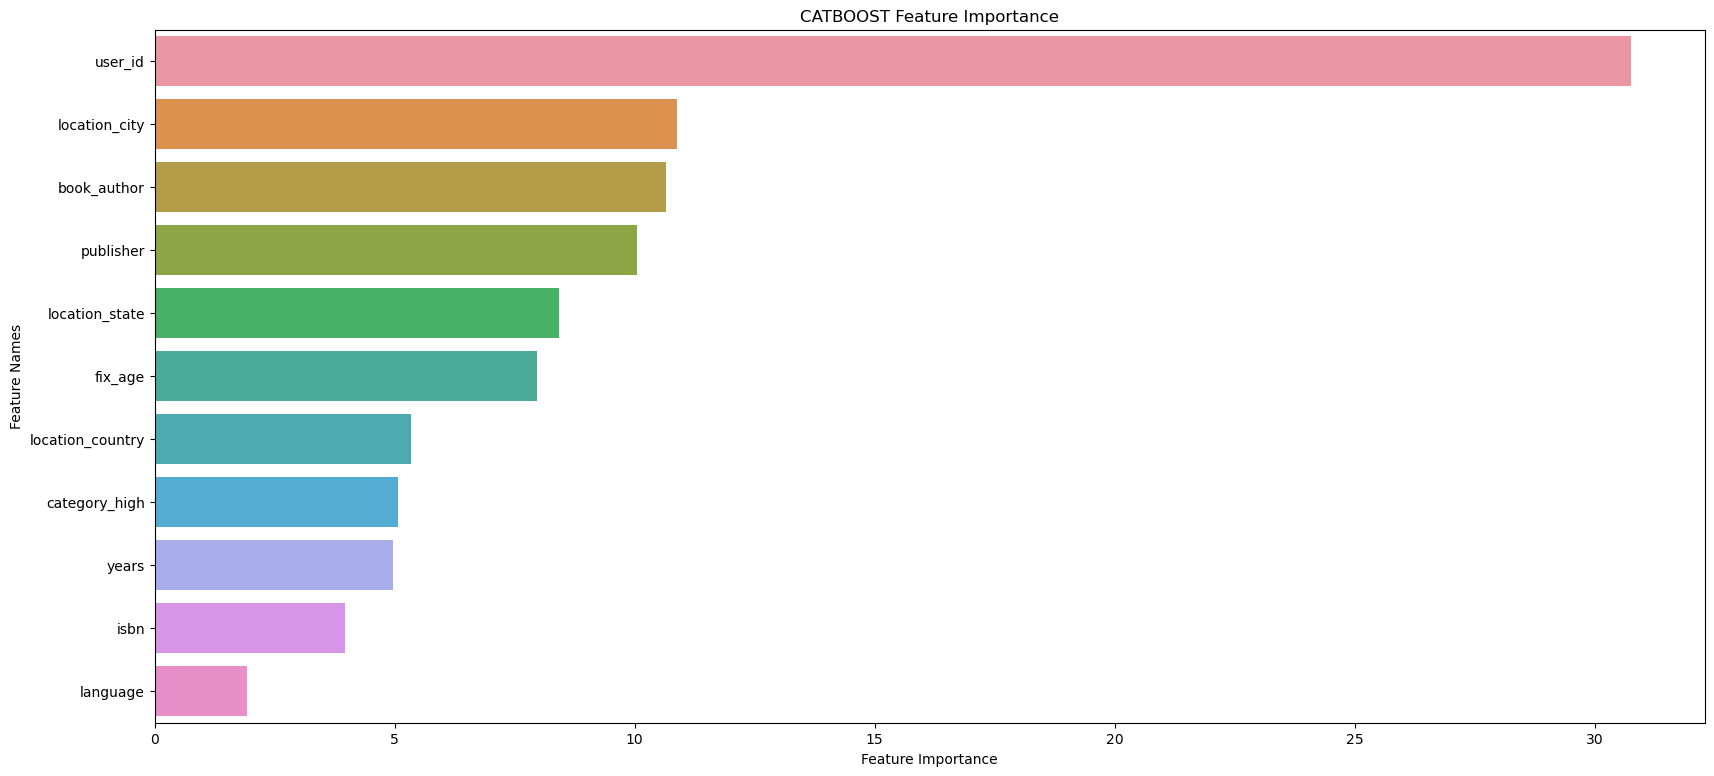

In [128]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()


plot_feature_importance(model.get_feature_importance(), train_ratings.drop(['rating'],axis = 1).columns, 'CATBOOST')